# Compound drought, hextreme fire weather and heatwaves in the observational record

In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

On Pearcey, nodes have 20 cores, each with 6GB. More than 20 cores, need more than one worker. `processes` ensures the number of workers.

In [406]:
cluster = SLURMCluster(processes=1,
                       walltime='01:30:00',
                       cores=2,
                       memory='12GB',
                       job_extra=['--qos="express"'])

In [407]:
cluster.scale(jobs=1)

In [410]:
client = Client(cluster)
client

Client Scheduler: tcp://10.141.1.62:45979 Dashboard: http://10.141.1.62:8787/status,Cluster Workers: 1 Cores: 2 Memory: 12.00 GB


In [409]:
# client.close()
# cluster.close()

In [154]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import cartopy.crs as ccrs

In [6]:
import carsa

# Plotting parameters

In [411]:
plt_params = {'font.size': 16,
              'ytick.major.size': 5}

In [412]:
plt_params = {'figure.figsize': [18.0, 8.0],
    
              'lines.linewidth': 2,
    
              'font.size': 16,
              
              'xtick.major.size': 5,
              'xtick.major.width': 1.5,
              'ytick.major.size': 5,
              'ytick.major.width': 1.5}

In [413]:
# default colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Set reference period as 1990-2019

In [414]:
ref_period = slice('1990', '2019')

# Load JRA55 data

In [415]:
jra_surface_ds = xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-jra55/surface_daily.zarr', consolidated=True)

In [416]:
jra_surface_ds = jra_surface_ds.rename({'g0_lat_1': 'lat',
                                        'g0_lon_2': 'lon',
                                        'initial_time0_hours': 'time'})

In [417]:
jra_surface_ds = jra_surface_ds.sel(lat=slice(-10, -45),
                                    lon=slice(110, 155))

In [418]:
jra_surface_ds.data_vars

Data variables:
    DEPR_GDS0_HTGL   (time, lat, lon) float32 dask.array<chunksize=(731, 29, 37), meta=np.ndarray>
    POT_GDS0_SFC     (time, lat, lon) float32 dask.array<chunksize=(731, 29, 37), meta=np.ndarray>
    PRES_GDS0_SFC    (time, lat, lon) float32 dask.array<chunksize=(731, 29, 37), meta=np.ndarray>
    PRMSL_GDS0_MSL   (time, lat, lon) float32 dask.array<chunksize=(731, 29, 37), meta=np.ndarray>
    RH_GDS0_HTGL     (time, lat, lon) float32 dask.array<chunksize=(731, 29, 37), meta=np.ndarray>
    SPFH_GDS0_HTGL   (time, lat, lon) float32 dask.array<chunksize=(731, 29, 37), meta=np.ndarray>
    SoilW_GDS0_ULN   (time, lv_ULN1, g0_lat_2, g0_lon_3) float32 dask.array<chunksize=(731, 1, 145, 288), meta=np.ndarray>
    TMAX_GDS4_HTGL   (time, lat, lon) float32 dask.array<chunksize=(731, 29, 37), meta=np.ndarray>
    TMP_GDS0_HTGL    (time, lat, lon) float32 dask.array<chunksize=(731, 29, 37), meta=np.ndarray>
    TPRAT_GDS0_SFC   (time, g0_lat_2, g0_lon_3) float32 dask.array<ch

# Define land mask using soil wetness variable

In [419]:
sw = jra_surface_ds['SoilW_GDS0_ULN'].isel(time=0, lv_ULN1=0) \
                                     .rename({'g0_lat_2': 'lat',
                                              'g0_lon_3': 'lon'})

In [420]:
jra_mask = sw.where(sw.isnull(), 1) \
             .compute()

# Heatwaves

- Define an extreme year as the 90th percentile of the greatest number of heatwave days per year (Jul-Jun).
- Heatwave days defined as when Excess Heat Factor (EHF) > 0.

In [421]:
temp = jra_surface_ds['TMP_GDS0_HTGL'].chunk({'time': -1})

In [422]:
EHF = carsa.excess_heat_factor(temp, climatology_slice=ref_period)

In [423]:
EHF = EHF.compute()

### Heatwave days

In [424]:
hw_days = xr.where(EHF > 0, 1, 0)

### Heatwave days per year

In [425]:
# per month
n_heatwave_days_pm = hw_days.resample(time='1MS').sum()

In [426]:
# per year (dpy = days per year)
# Shift forward 6 months so that a yearly aggregation is Jul-Jun. Exclude 1958 as this now only has data for half a year.
heatwave_dpy = n_heatwave_days_pm.shift(time=6) \
                                 .sel(time=slice('1959', '2020')) \
                                 .resample(time='1YS').sum()

### Heatwave events

In [427]:
def cumsum_event(x):
    """
        For each column in x, calculates the cumulative sum, resetting when a zero is encountered.
        
        Parameters
        ----------
        x : numpy array
            2D array where the second axis is to be operated along.
            
        Returns
        -------
        array
            2D array where the second axis is the cumulative sums with zero reset.
    """
    x = pd.DataFrame(x)
    return x.transform(lambda x: x.groupby(x.eq(0).cumsum()).cumsum()).values

In [428]:
def cumsum_event_da(da, time_name='time', lat_name='lat', lon_name='lon'):
    """
        Applied cumsum_event along time dimension of a DataArray, preserving dimensions etc.
        
        Parameters
        ----------
        da : xarray DataArray
            Array to operate on. Typically this will be filled with zeros and ones,
            where ones are used to indicate the occurrence of an event.
            
        Returns
        -------
        cumsum_3d : xarray DataArray
            Array of cumulative sums along the time dimension, indicating the presence
            and length of an event.
    """
    da = da.transpose(time_name, ...)
    da_shape = da.values.shape
    da_2d = da.values.reshape((da_shape[0], da_shape[1] * da_shape[2]))
    cumsum_2d = cumsum_event(da_2d)
    cumsum_3d = cumsum_2d.reshape(da_shape)
    
    return xr.DataArray(cumsum_3d, coords=da.coords, dims=da.dims)

In [429]:
hw_events = cumsum_event_da(hw_days)

### Number of heatwaves per year

In [430]:
# End of heatwave event is when the difference in binary or cumulative heatwaves days is negative
# Shift forward 6 months so that a year contains data from Jul-Jun.
hw_events_py = xr.where(hw_events.diff('time') < -1, 1, 0) \
                .resample(time='1MS').sum() \
                .shift(time=6) \
                .sel(time=slice('1959', '2020')) \
                .resample(time='1YS').sum() \
                .rename('n_events')

### Maximum heatwave length per year

In [431]:
max_yearly_hw_len = hw_events.resample(time='1MS').max() \
                             .shift(time=6) \
                             .sel(time=slice('1959', '2020')) \
                             .resample(time='1YS').max() \
                             .rename('length')

### Heatwave intensity (EHF on heatwave days)

In [432]:
hw_intensity = hw_days * EHF # Average EHF on heatwave days

### Exploratory EHF figures

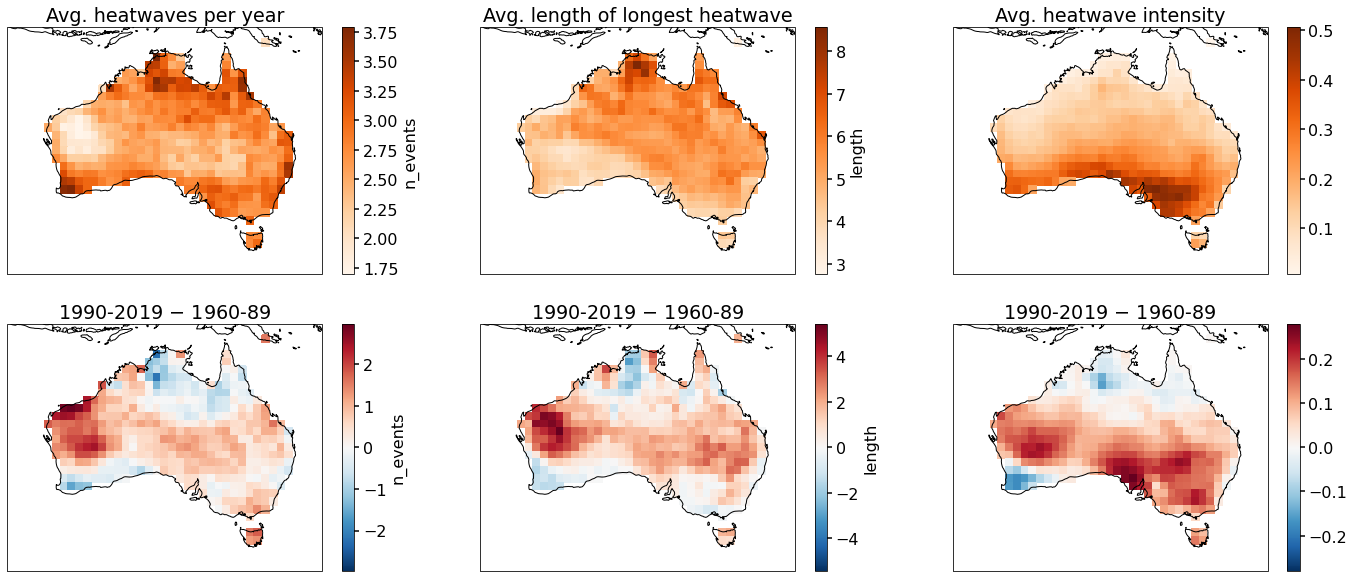

In [433]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(2, 3, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Mean heatwaves per year
    ax[0,0].coastlines()
    hw_events_py.mean('time').where(jra_mask == 1).plot(ax=ax[0,0], cmap='Oranges')
    ax[0,0].set_title('Avg. heatwaves per year')
    
    # Mean maximum-length heatwave
    ax[0,1].coastlines()
    max_yearly_hw_len.mean('time').where(jra_mask == 1).plot(ax=ax[0,1], cmap='Oranges')
    ax[0,1].set_title('Avg. length of longest heatwave')
    
    # Mean heatwave intensity (EHF)
    ax[0,2].coastlines()
    hw_intensity.mean('time').where(jra_mask == 1).plot(ax=ax[0,2], cmap='Oranges')
    ax[0,2].set_title('Avg. heatwave intensity')
    
    # Difference between 1989-2020 and 1958-1988 -----------
    ax[1,0].coastlines()
    (hw_events_py.sel(time=slice('1990', '2019')).mean('time') - hw_events_py.sel(time=slice('1960', '1989')).mean('time')).where(jra_mask == 1).plot(ax=ax[1,0])
    ax[1,0].set_title(r'1990-2019 $-$ 1960-89')
    
    ax[1,1].coastlines()
    (max_yearly_hw_len.sel(time=slice('1990', '2019')).mean('time') - max_yearly_hw_len.sel(time=slice('1960', '1989')).mean('time')).where(jra_mask == 1).plot(ax=ax[1,1])
    ax[1,1].set_title(r'1990-2019 $-$ 1960-89')
    
    ax[1,2].coastlines()
    (hw_intensity.sel(time=slice('1990', '2019')).mean('time') - hw_intensity.sel(time=slice('1960', '1989')).mean('time')).where(jra_mask == 1).plot(ax=ax[1,2])
    ax[1,2].set_title(r'1990-2019 $-$ 1960-89')

### Define years that are extreme in terms of heatwaves

- 10% of years with the highest number of heatwave days

In [434]:
heatwave_year_thresh = heatwave_dpy.sel(time=ref_period) \
                                   .reduce(np.nanpercentile, q=90, dim='time')

In [435]:
heatwave_dpy = heatwave_dpy.to_dataset(name='heatwave_days')

In [436]:
heatwave_dpy['heatwave_year'] = xr.where(heatwave_dpy['heatwave_days'] > heatwave_year_thresh, 1, 0)

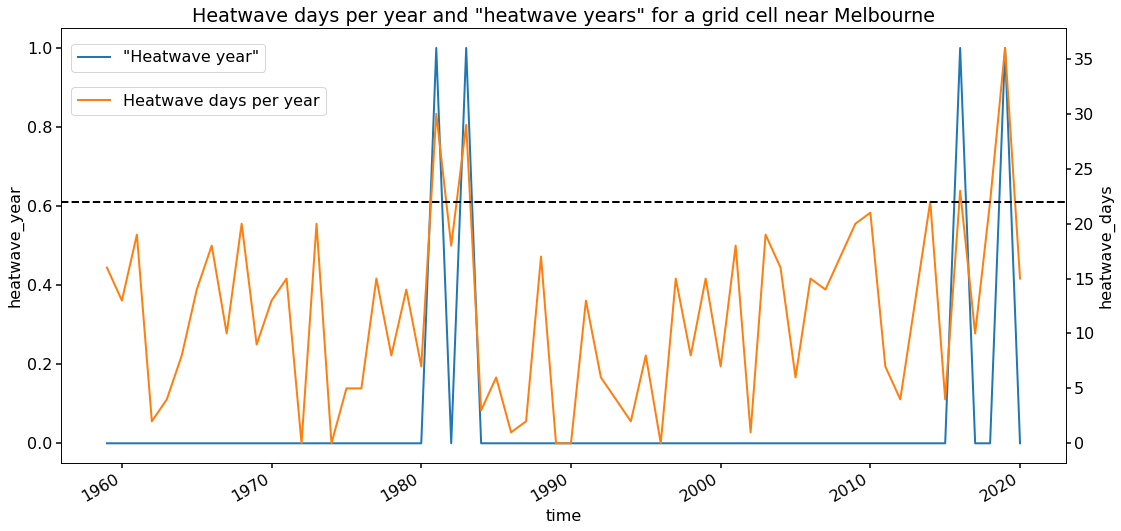

In [437]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(1, 1)
    
    heatwave_dpy.heatwave_year.sel(lat=-35, lon=145).plot(ax=ax, label='"Heatwave year"')
    ax.legend(loc=(0.01,0.9))
    ax.set_title('')
    
    ax2=ax.twinx()
    heatwave_dpy.heatwave_days.sel(lat=-35, lon=145).plot(ax=ax2, color=colors[1], label='Heatwave days per year')
    ax2.axhline(heatwave_year_thresh.sel(lat=-35, lon=145), color='k', ls='--')
    ax2.legend(loc=(0.01,0.8))
    ax2.set_title('Heatwave days per year and "heatwave years" for a grid cell near Melbourne')

# Fire weather

- Extreme fire weather years are the top 10% of years in terms of number of extreme FFDI days.
- An extreme FFDI day is that above the 95th percentile.

In [438]:
precip = jra_surface_ds['TPRAT_GDS0_SFC'].rename({'g0_lat_2': 'lat',
                                                  'g0_lon_3': 'lon'}) \
                                         .sel(lat=slice(-10, -45),
                                              lon=slice(110, 155))
rh = jra_surface_ds['RH_GDS0_HTGL']
tmax = jra_surface_ds['TMAX_GDS4_HTGL'] - 273.15 # convert to deg C
wmax = jra_surface_ds['WSMX_GDS4_HTGL'] * 3.6 # convert to km/h

In [439]:
FFDI = carsa.FFDI(precip, rh, tmax, wmax)

In [440]:
FFDI = FFDI.compute()

### Define extreme FFDI days as those above 95th percentile

In [441]:
FFDI_thresh = FFDI.sel(time=ref_period) \
                  .reduce(np.nanpercentile, q=95, dim='time')

In [442]:
FFDI_extreme = xr.where(FFDI > FFDI_thresh, 1, 0)

### Extreme days per year (Jul-Jun)

In [443]:
extreme_FFDI_dpm = FFDI_extreme.resample(time='1MS').sum()

In [444]:
extreme_FFDI_dpy = extreme_FFDI_dpm.shift(time=6) \
                                   .resample(time='1YS').sum() \
                                   .sel(time=slice('1959', '2020'))

## Extreme fire weather years

In [445]:
extreme_FFDI_year_thresh = extreme_FFDI_dpy.sel(time=ref_period) \
                                           .reduce(np.nanpercentile, q=90, dim='time')

In [446]:
extreme_FFDI = extreme_FFDI_dpy.to_dataset(name='extreme_dpy')

In [447]:
extreme_FFDI['extreme_year'] = xr.where(extreme_FFDI['extreme_dpy'] > extreme_FFDI_year_thresh, 1, 0)

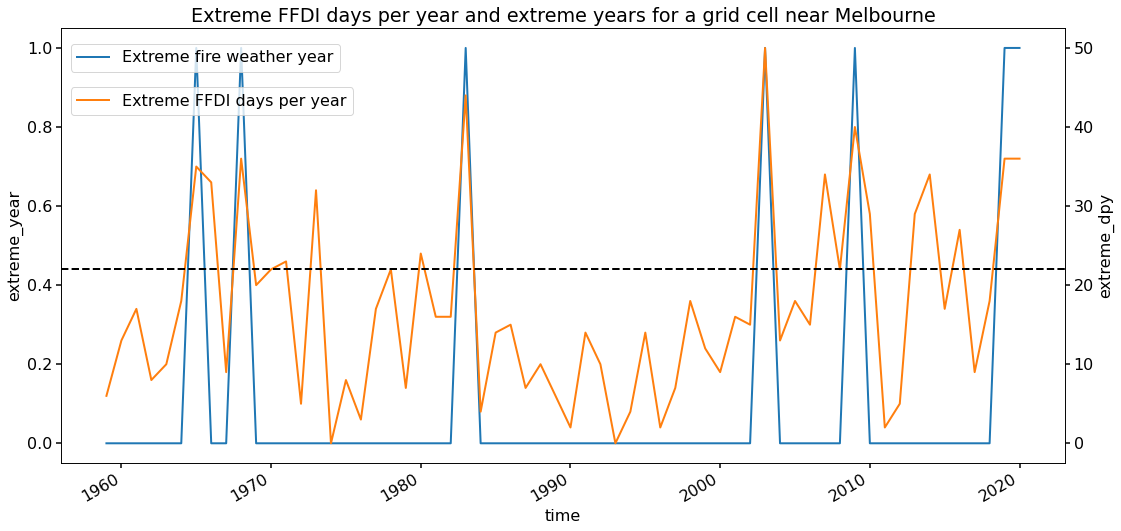

In [448]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(1, 1)
    
    extreme_FFDI['extreme_year'].sel(lat=-35, lon=145).plot(ax=ax, label='Extreme fire weather year')
    ax.legend(loc=(0.01,0.9))
    ax.set_title('')
    
    ax2=ax.twinx()
    extreme_FFDI['extreme_dpy'].sel(lat=-35, lon=145).plot(ax=ax2, color=colors[1], label='Extreme FFDI days per year')
    ax2.axhline(heatwave_year_thresh.sel(lat=-35, lon=145), color='k', ls='--')
    ax2.legend(loc=(0.01,0.8))
    ax2.set_title('Extreme FFDI days per year and extreme years for a grid cell near Melbourne')

# Drought

- 10th percentile annual (Jan-Dec) rainfall from AWAP.

In [449]:
awap_p = xr.open_zarr('/scratch1/projects/dcfp/data/csiro-dcfp-csiro-awap/rain_day_19000101-20210117_jra-grid.zarr', consolidated=True)

In [450]:
awap_p = awap_p.sel(time=slice('1958', '2020'))

In [451]:
awap_p = awap_p.resample(time='1YS').sum()

### Shift forward one year so that drought years align with FFDI/EHF years (use last year of FFDI/EHF to denote the year).

E.g. Precipitation in 1958 is labelled as 1959 to align with the 1958/59 fire weather / heatwave years.

In [452]:
awap_p = awap_p.shift(time=1) \
               .sel(time=slice('1959', '2020'))

In [453]:
awap_p = awap_p.compute()

In [454]:
drought_thresh = awap_p.precip \
                       .sel(time=ref_period) \
                       .reduce(np.nanpercentile, q=10, dim='time')

### Drought years

In [455]:
awap_p['drought_year'] = xr.where(awap_p.precip < drought_thresh, 1, 0)

In [456]:
awap_p = awap_p[['precip', 'drought_year']]

In [457]:
awap_p = awap_p * jra_mask

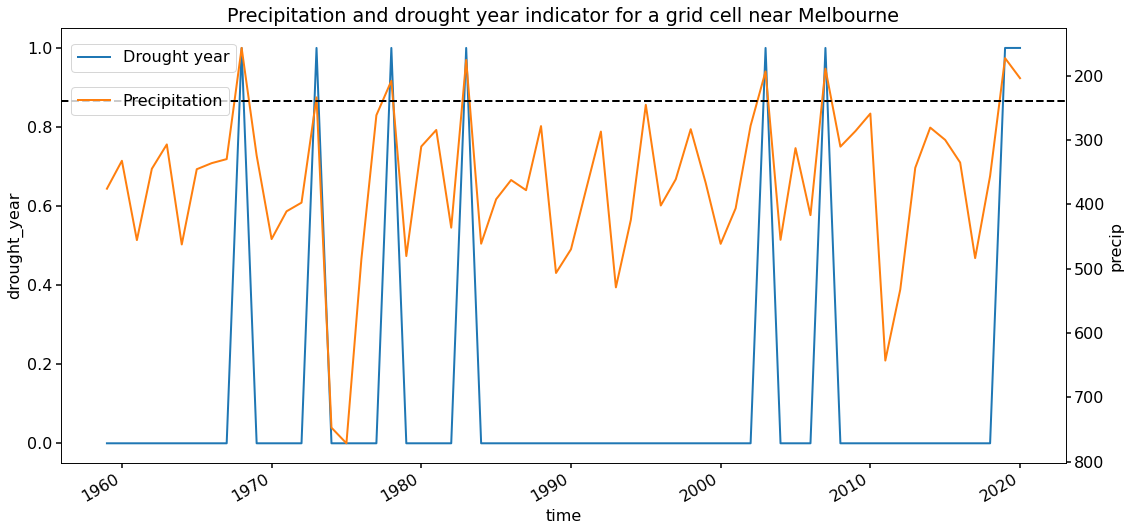

In [458]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(1, 1)
    
    awap_p['drought_year'].sel(lat=-35, lon=145).plot(ax=ax, label='Drought year')
    ax.legend(loc=(0.01,0.9))
    ax.set_title('')
    
    ax2=ax.twinx()
    awap_p['precip'].sel(lat=-35, lon=145).plot(ax=ax2, color=colors[1], label='Precipitation')
    ax2.axhline(drought_thresh.sel(lat=-35, lon=145), color='k', ls='--')
    ax2.legend(loc=(0.01,0.8))
    ax2.invert_yaxis()
    ax2.set_title('Precipitation and drought year indicator for a grid cell near Melbourne')

# Compound drought, fire risk and heatwave years

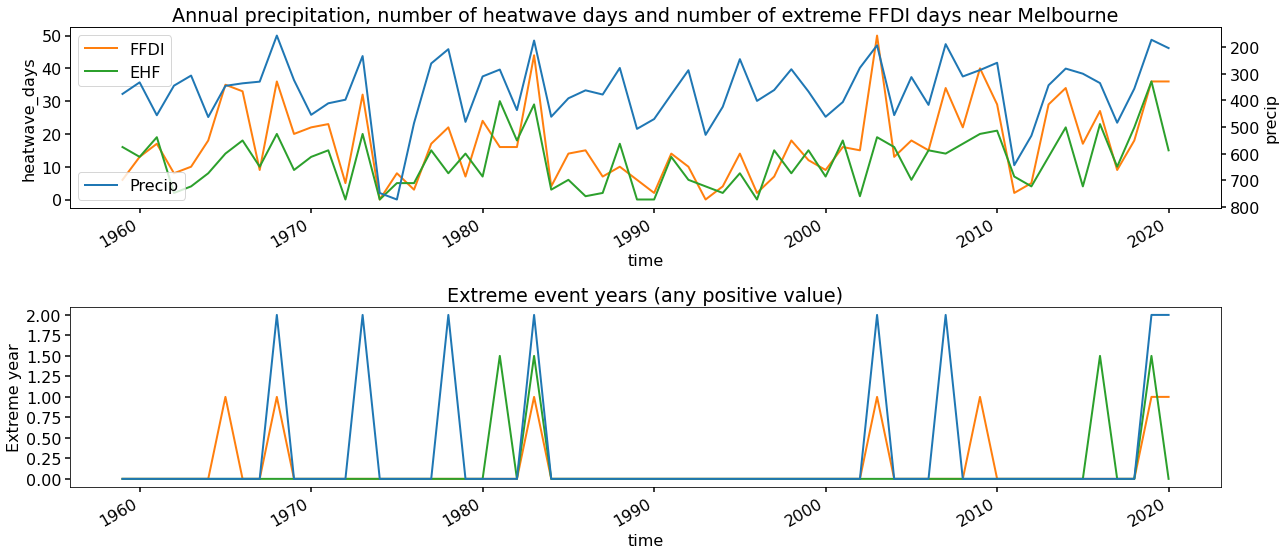

In [459]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(2, 1)
    
    # Extreme FFDI days per year
    extreme_FFDI['extreme_dpy'].sel(lat=-35, lon=145).plot(ax=ax[0], color=colors[1], label='FFDI')
    
    # Heatwave days per year
    heatwave_dpy['heatwave_days'].sel(lat=-35, lon=145).plot(ax=ax[0], color=colors[2], label='EHF')
    
    ax[0].legend()
    
    ax2 = ax[0].twinx()
    awap_p['precip'].sel(lat=-35, lon=145, time=slice('1959', '2020')).plot(ax=ax2, color=colors[0], label='Precip')
    ax2.invert_yaxis()
    ax2.legend(loc='lower left')
    ax[0].set_title('')
    ax2.set_title('Annual precipitation, number of heatwave days and number of extreme FFDI days near Melbourne')
    
    extreme_FFDI['extreme_year'].sel(lat=-35, lon=145).plot(ax=ax[1], color=colors[1])
    (1.5 * heatwave_dpy['heatwave_year'].sel(lat=-35, lon=145)).plot(ax=ax[1], color=colors[2])
    (2 * awap_p['drought_year'].sel(lat=-35, lon=145, time=slice('1959', '2020'))).plot(ax=ax[1], color=colors[0])
    ax[1].set_title('Extreme event years (any positive value)')
    ax[1].set_ylabel('Extreme year')

    plt.tight_layout()

# Correspondence of drought, fire weather and heatwave years

In [460]:
compound_extremes = (awap_p['drought_year'] + extreme_FFDI['extreme_year']) \
                    .to_dataset(name='drought_fire_weather')

In [461]:
compound_extremes['drought_heatwave'] = awap_p['drought_year'] + heatwave_dpy['heatwave_year']

In [462]:
compound_extremes['heatwave_fire_weather'] = heatwave_dpy['heatwave_year'] + extreme_FFDI['extreme_year']

In [463]:
compound_extremes['all'] = awap_p['drought_year'] + heatwave_dpy['heatwave_year'] + extreme_FFDI['extreme_year']

# Percentage of extreme years for all combinations of each hazard

- Note this is relative to the 1990-2018 baseline, so a 10% frequency of a single hazard is not guaranteed (see heatwaves plot below).

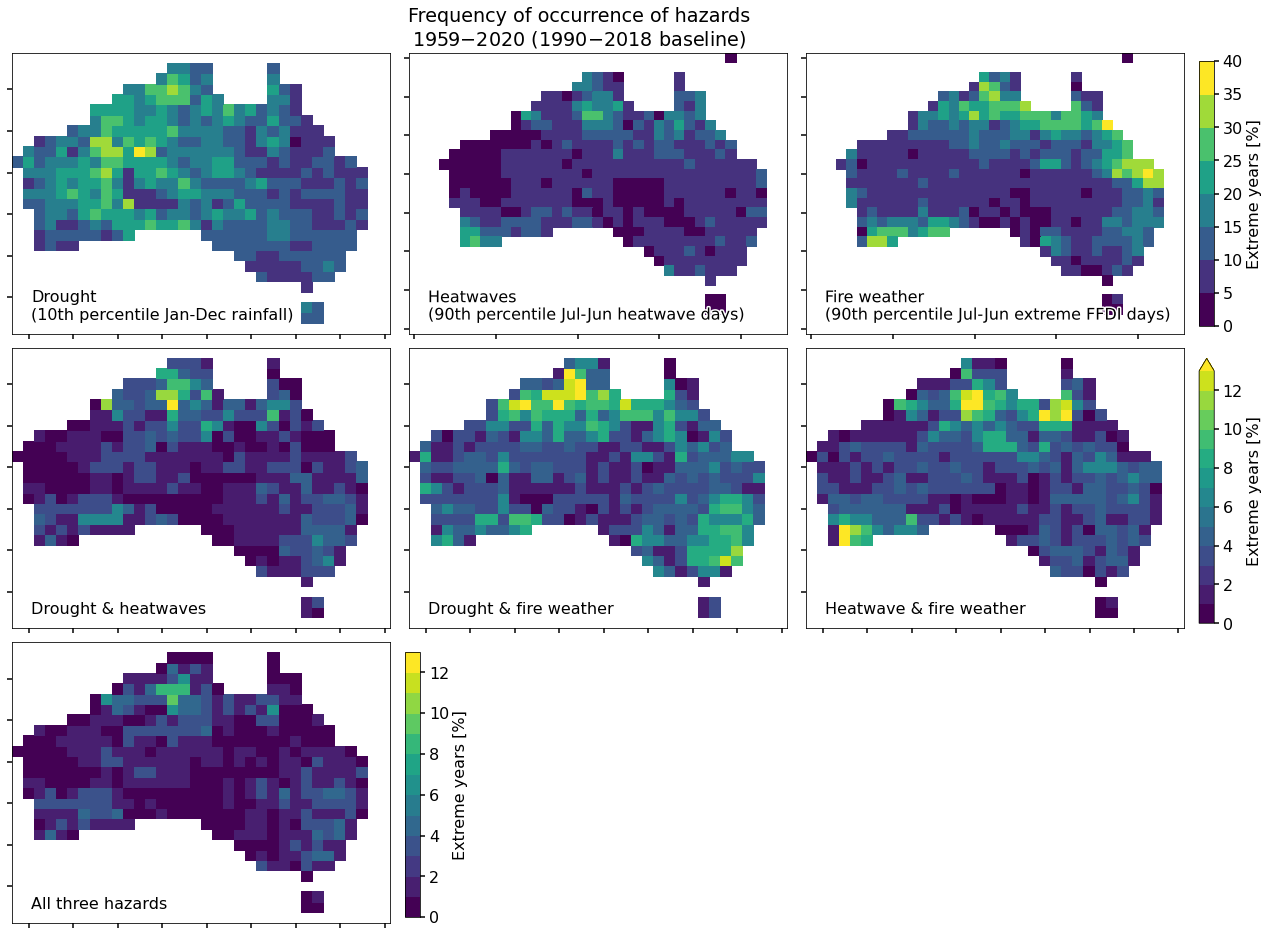

In [464]:
with plt.rc_context(plt_params):
    add_cbar = False
    levels = np.arange(0, 41, 5)
    levels2 = np.arange(0, 14, 1)
    levels3 = np.arange(0, 14, 1)
    
    fig, ax = plt.subplots(3, 3, figsize=(21, 16))
    
    nYears = len(range(1959, 2021))
    
    # % of drought years
    da = awap_p['drought_year'].sum('time')
    da = da / nYears * 100
    p = da.where(jra_mask == 1) \
          .plot(ax=ax[0,0],
                levels=levels,
                add_colorbar=add_cbar)
    ax[0,0].text(0.05, 0.05, 'Drought\n(10th percentile Jan-Dec rainfall)', transform=ax[0,0].transAxes)
    
    # % of heatwave years
    da = heatwave_dpy['heatwave_year'].sum('time')
    da = da / n_years * 100
    da.where(jra_mask == 1) \
      .plot(ax=ax[0,1],
            levels=levels,
            add_colorbar=add_cbar)
    ax[0,1].text(0.05, 0.05, 'Heatwaves\n(90th percentile Jul-Jun heatwave days)', transform=ax[0,1].transAxes,
                path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    # % of fire risk years
    da = extreme_FFDI['extreme_year'].sum('time')
    da = da / n_years * 100
    da.where(jra_mask == 1) \
      .plot(ax=ax[0,2],
            levels=levels,
            add_colorbar=add_cbar)
    ax[0,2].text(0.05, 0.05, 'Fire weather\n(90th percentile Jul-Jun extreme FFDI days)', transform=ax[0,2].transAxes,
                path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    # % of drought + heatwave years
    da = xr.where(compound_extremes['drought_heatwave'] == 2, 1, 0) \
        .sum('time')
    da = da / n_years * 100
    da.where(jra_mask == 1) \
      .plot(ax=ax[1,0],
            levels=levels2,
            add_colorbar=add_cbar)
    ax[1,0].text(0.05, 0.05, 'Drought & heatwaves', transform=ax[1,0].transAxes)
    
    # % of drought + fire risk years
    (xr.where(compound_extremes['drought_fire_weather'] == 2, 1, 0) \
                                    .sum('time')
                                    / n_years * 100) \
                                    .where(jra_mask == 1) \
                                    .plot(ax=ax[1,1], levels=levels2,
                                          add_colorbar=add_cbar)
    ax[1,1].text(0.05, 0.05, 'Drought & fire weather', transform=ax[1,1].transAxes)
    
    # Number of consecutive heatwave + fire risk years
    da = xr.where(compound_extremes['heatwave_fire_weather'] == 2, 1, 0) \
         .sum('time')
    da = da / n_years * 100
    p2 = da.where(jra_mask == 1) \
           .plot(ax=ax[1,2],
                 levels=levels2,
                 add_colorbar=add_cbar)
    ax[1,2].text(0.05, 0.05, 'Heatwave & fire weather', transform=ax[1,2].transAxes)
    
    # % of drought + heatwave + fire risk years
    da = xr.where(compound_extremes['all'] == 3, 1, 0) \
         .sum('time')
    da = da / n_years * 100
    p3 = da.where(jra_mask == 1) \
            .plot(ax=ax[2,0],
                  levels=levels3,
                  add_colorbar=add_cbar)
    ax[2,0].text(0.05, 0.05, 'All three hazards', transform=ax[2,0].transAxes)
    
    for a in ax.flatten():
        a.set_xlabel('')
        a.set_ylabel('')
        a.set_xticklabels('')
        a.set_yticklabels('')
        a.set_title('')
        
    ax[2,1].axis('off')
    ax[2,2].axis('off')
        
    cb_ax = fig.add_axes([0.91, 0.643, 0.01, 0.23])
    cb = fig.colorbar(p, cax=cb_ax, orientation='vertical')
    cb.set_label('Extreme years [%]')
    
    cb_ax = fig.add_axes([0.91, 0.385, 0.01, 0.23])
    cb = fig.colorbar(p2, cax=cb_ax, orientation='vertical')
    cb.set_label('Extreme years [%]')
    
    cb_ax = fig.add_axes([0.385, 0.13, 0.01, 0.23])
    cb = fig.colorbar(p3, cax=cb_ax, orientation='vertical')
    cb.set_label('Extreme years [%]')
    
    plt.suptitle('Frequency of occurrence of hazards\n'+r'1959$-$2020 (1990$-$2018 baseline)', y=0.92)
    
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

# Number of sequential hazard years

### Calculate cumulative extreme years for FFDI, EHF and precip

In [465]:
cumulative_extremes = cumsum_event_da(extreme_FFDI['extreme_year']) \
                      .to_dataset(name='fire_weather')

In [466]:
cumulative_extremes['heatwave'] = cumsum_event_da(heatwave_dpy['heatwave_year'])

In [467]:
cumulative_extremes['drought'] = cumsum_event_da(awap_p['drought_year'])

In [468]:
cumulative_extremes['drought_fire_weather'] = cumsum_event_da(xr.where(compound_extremes['drought_fire_weather'] > 1, 1, 0))

In [469]:
cumulative_extremes['drought_heatwave'] = cumsum_event_da(xr.where(compound_extremes['drought_heatwave'] > 1, 1, 0))

In [470]:
cumulative_extremes['heatwave_fire_weather'] = cumsum_event_da(xr.where(compound_extremes['heatwave_fire_weather'] > 1, 1, 0))

In [471]:
cumulative_extremes['all'] = cumsum_event_da(xr.where(compound_extremes['all'] > 2, 1, 0))

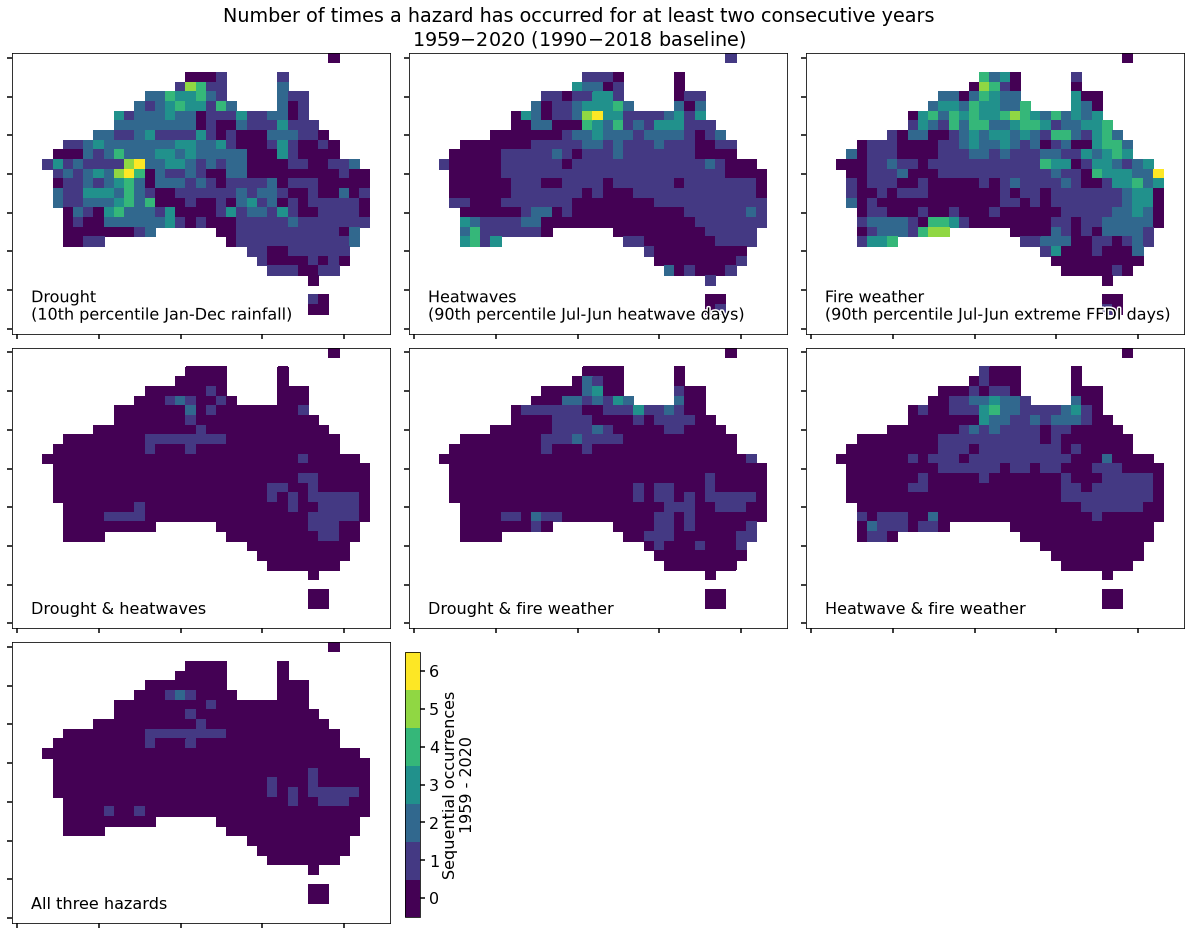

In [472]:
with plt.rc_context(plt_params):
    add_cbar = False
    levels = range(8)
    fig, ax = plt.subplots(3, 3, figsize=(21, 16))
    
    # Number of consecutive drought years
    cumulative_extremes['drought'].where(cumulative_extremes['drought'] == 2) \
                                  .count('time') \
                                  .where(jra_mask == 1) \
                                  .plot(ax=ax[0,0],
                                        levels=levels,
                                        add_colorbar=add_cbar)
    ax[0,0].text(0.05, 0.05, 'Drought\n(10th percentile Jan-Dec rainfall)', transform=ax[0,0].transAxes,
                 path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    # Number of consecutive heatwave years
    cumulative_extremes['heatwave'].where(cumulative_extremes['heatwave'] == 2) \
                                   .count('time') \
                                   .where(jra_mask == 1) \
                                   .plot(ax=ax[0,1],
                                         levels=levels,
                                         add_colorbar=add_cbar)
    ax[0,1].text(0.05, 0.05, 'Heatwaves\n(90th percentile Jul-Jun heatwave days)', transform=ax[0,1].transAxes,
                 path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    # Number of consecutive fire risk years
    cumulative_extremes['fire_weather'].where(cumulative_extremes['fire_weather'] == 2) \
                                       .count('time') \
                                       .where(jra_mask == 1) \
                                       .plot(ax=ax[0,2],
                                             levels=levels,
                                             add_colorbar=add_cbar)
    ax[0,2].text(0.05, 0.05, 'Fire weather\n(90th percentile Jul-Jun extreme FFDI days)', transform=ax[0,2].transAxes,
                 path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    # Number of consecutive drought + heatwave years
    cumulative_extremes['drought_heatwave'].where(cumulative_extremes['drought_heatwave'] == 2) \
                                           .count('time') \
                                           .where(jra_mask == 1) \
                                           .plot(ax=ax[1,0],
                                                 levels=levels,
                                                 add_colorbar=add_cbar)
    ax[1,0].text(0.05, 0.05, 'Drought & heatwaves', transform=ax[1,0].transAxes)
    
    # Number of consecutive drought + fire risk years
    cumulative_extremes['drought_fire_weather'].where(cumulative_extremes['drought_fire_weather'] == 2) \
                                               .count('time') \
                                               .where(jra_mask == 1) \
                                               .plot(ax=ax[1,1],
                                                     levels=levels,
                                                     add_colorbar=add_cbar)
    ax[1,1].text(0.05, 0.05, 'Drought & fire weather', transform=ax[1,1].transAxes)
    
    # Number of consecutive heatwave + fire risk years
    cumulative_extremes['heatwave_fire_weather'].where(cumulative_extremes['heatwave_fire_weather'] == 2) \
                                                .count('time') \
                                                .where(jra_mask == 1) \
                                                .plot(ax=ax[1,2],
                                                      levels=levels,
                                                      add_colorbar=add_cbar)
    ax[1,2].text(0.05, 0.05, 'Heatwave & fire weather', transform=ax[1,2].transAxes)
    
    # Number of consecutive drought + heatwave + fire risk years
    p = cumulative_extremes['all'].where(cumulative_extremes['all'] == 2) \
                                  .count('time') \
                                  .where(jra_mask == 1) \
                                  .plot(ax=ax[2,0],
                                        levels=levels,
                                        add_colorbar=add_cbar)
    ax[2,0].text(0.05, 0.05, 'All three hazards', transform=ax[2,0].transAxes)
    
    for a in ax.flatten():
        a.set_xlabel('')
        a.set_ylabel('')
        a.set_xticklabels('')
        a.set_yticklabels('')
        a.set_title('')
        
    ax[2,1].axis('off')
    ax[2,2].axis('off')
    
    cb_ax = fig.add_axes([0.385, 0.13, 0.01, 0.23])
    cb = fig.colorbar(p, cax=cb_ax, orientation='vertical', ticks=np.arange(0.5, 7.5))
    cb.ax.set_yticklabels(range(7))
    cb.set_label('Sequential occurrences\n1959 - 2020')
    
    plt.suptitle('Number of times a hazard has occurred for at least two consecutive years\n'+r'1959$-$2020 (1990$-$2018 baseline)', y=0.92)
    
    plt.subplots_adjust(hspace=0.05, wspace=0.05)

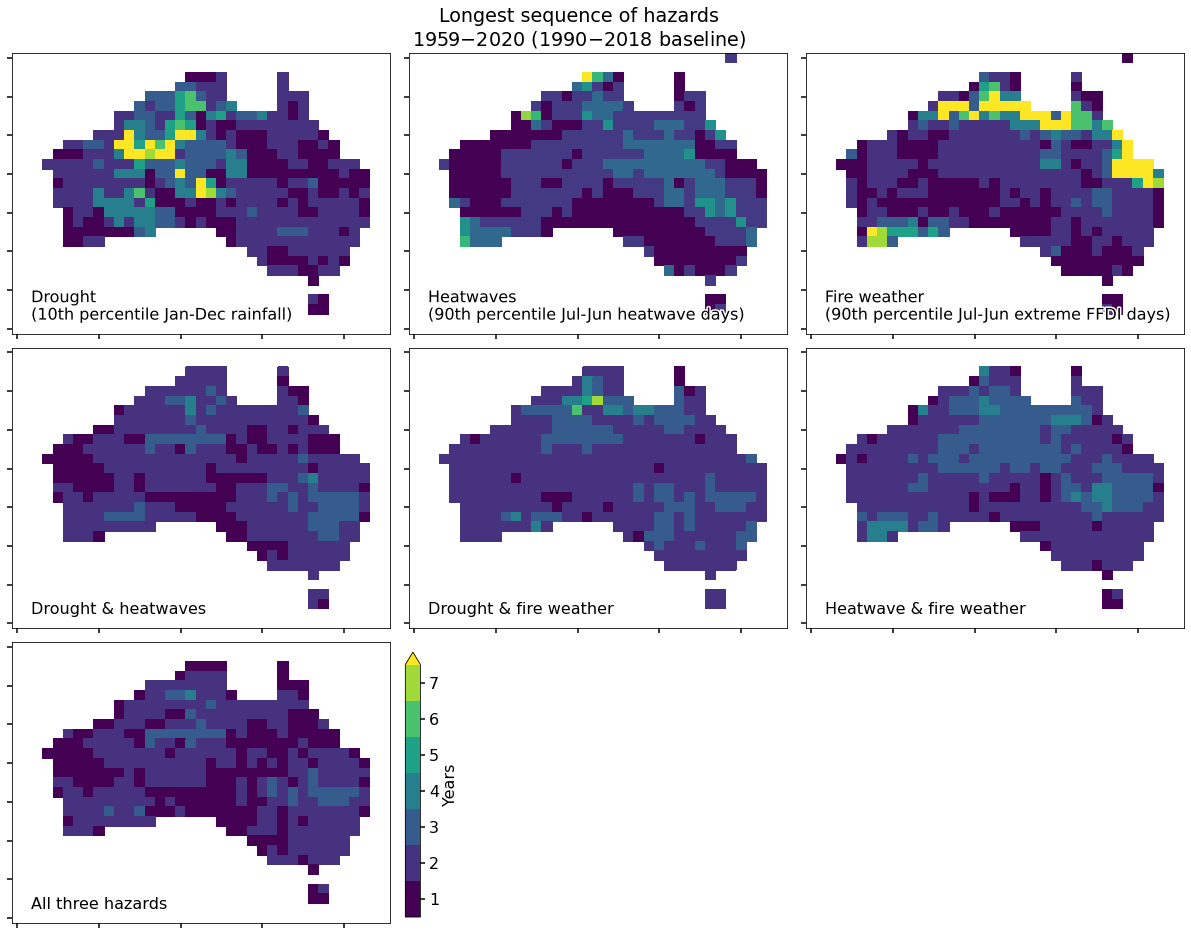

In [473]:
with plt.rc_context(plt_params):
    add_cbar = False
    levels = range(1,9)
    fig, ax = plt.subplots(3, 3, figsize=(21, 16))
    
    # Number of consecutive drought years
    p=cumulative_extremes['drought'].max('time') \
                                  .where(jra_mask == 1) \
                                  .plot(ax=ax[0,0],
                                        levels=levels,
                                        add_colorbar=add_cbar)
    ax[0,0].text(0.05, 0.05, 'Drought\n(10th percentile Jan-Dec rainfall)', transform=ax[0,0].transAxes,
                 path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    # Number of consecutive heatwave years
    cumulative_extremes['heatwave'].max('time') \
                                   .where(jra_mask == 1) \
                                   .plot(ax=ax[0,1],
                                         levels=levels,
                                         add_colorbar=add_cbar)
    ax[0,1].text(0.05, 0.05, 'Heatwaves\n(90th percentile Jul-Jun heatwave days)', transform=ax[0,1].transAxes,
                 path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    # Number of consecutive fire risk years
    cumulative_extremes['fire_weather'].max('time') \
                                       .where(jra_mask == 1) \
                                       .plot(ax=ax[0,2],
                                             levels=levels,
                                             add_colorbar=add_cbar)
    ax[0,2].text(0.05, 0.05, 'Fire weather\n(90th percentile Jul-Jun extreme FFDI days)', transform=ax[0,2].transAxes,
                 path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")])
    
    # Number of consecutive drought + heatwave years
    cumulative_extremes['drought_heatwave'].max('time') \
                                           .where(jra_mask == 1) \
                                           .plot(ax=ax[1,0],
                                                 levels=levels,
                                                 add_colorbar=add_cbar)
    ax[1,0].text(0.05, 0.05, 'Drought & heatwaves', transform=ax[1,0].transAxes)
    
    # Number of consecutive drought + fire risk years
    cumulative_extremes['drought_fire_weather'].max('time') \
                                               .where(jra_mask == 1) \
                                               .plot(ax=ax[1,1],
                                                     levels=levels,
                                                     add_colorbar=add_cbar)
    ax[1,1].text(0.05, 0.05, 'Drought & fire weather', transform=ax[1,1].transAxes)
    
    # Number of consecutive heatwave + fire risk years
    cumulative_extremes['heatwave_fire_weather'].max('time') \
                                                .where(jra_mask == 1) \
                                                .plot(ax=ax[1,2],
                                                      levels=levels,
                                                      add_colorbar=add_cbar)
    ax[1,2].text(0.05, 0.05, 'Heatwave & fire weather', transform=ax[1,2].transAxes)
    
    # Number of consecutive drought + heatwave + fire risk years
    cumulative_extremes['all'].max('time') \
                                  .where(jra_mask == 1) \
                                  .plot(ax=ax[2,0],
                                        levels=levels,
                                        add_colorbar=add_cbar)
    ax[2,0].text(0.05, 0.05, 'All three hazards', transform=ax[2,0].transAxes)
    
    for a in ax.flatten():
        a.set_xlabel('')
        a.set_ylabel('')
        a.set_xticklabels('')
        a.set_yticklabels('')
        a.set_title('')
        
    ax[2,1].axis('off')
    ax[2,2].axis('off')
    
    cb_ax = fig.add_axes([0.385, 0.13, 0.01, 0.23])
    cb = fig.colorbar(p, cax=cb_ax, orientation='vertical', ticks=np.arange(1.5, 8.5))
    cb.ax.set_yticklabels(range(1,8))
    cb.set_label('Years')
    
    plt.suptitle('Longest sequence of hazards\n'+r'1959$-$2020 (1990$-$2018 baseline)', y=0.92)
    
    plt.subplots_adjust(hspace=0.05, wspace=0.05)